### Base Florence-2 Model

This notebook serves as an intro to Florance 2 base performance and shows some examples of the types of tasks it can acomplish.

Florence-2 is a vision foundation model trained by Microsoft in 2023. It has good out of the box performance at a variety of image tasks. It produces predictions by outputing text tokens, with a limit of 1024 per image. To designate parts of the image, normalised x, y co-ordinates are produced by the model.

This notebook details how to use Florence-2 and its base model. We need to specify both a task type and a specific prompt for further instructions.

Task Types (a sample of the main tasks), input as a prompt:
- `<CAPTION>` Description
- `<DETAILED_CAPTION>` Description
- `<OD>` Object detection
- `<REFERRING_EXPRESSION_SEGMENTATION>` Segmentation, given text
- `<REGION_TO_SEGMENTATION>` Segmentation, given a bounding box
- `<OCR>` Optical Character Recognition
- `<OCR_WITH_REGION>` Optical Character Recognition which also provides a bounding box

We can also add regions by specifying the task with `<loc1><loc2><loc3><loc4>` after the task type above, ie `<TASK><loc1><loc2><loc3><loc4>`.

Alternative:
- VQA: What does the image describe?
- VQA: What does the region `<loc1><loc2><loc3><loc4>` describe?
- Object Detection: Locate objects in the image.
- Object Detection: Locate the phrases in the caption: `<loc1><loc2><loc3><loc4>`.
- Segmentation: What is the polygon mask of region `<loc1><loc2><loc3><loc4>`?
- OCR: Extract text with region `<loc1><loc2><loc3><loc4>`.

For full details of the training, see the paper: https://arxiv.org/abs/2311.06242

#### Setup model and import libraries

In [3]:
# import libraries
import os
import torch
from transformers import AutoProcessor, AutoModelForCausalLM 

# import custom libraries
from utils.image_functions import read_image, display_image
from utils.florence_functions import obj_det_florence

# setup device and dtype if using GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print(f"DEVICE: {device} \nTORCH DTYPE: {torch_dtype}")

# Load model and processor from Hugging Face
# microsoft/Florence-2-large-ft is the fine-tuned version of microsoft/Florence-2-large. It is finetuned for a variety of downstream tasks.
model_name = "microsoft/Florence-2-large-ft" # microsoft/Florence-2-large
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch_dtype, trust_remote_code=True).eval().to(device)
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)

# setup correct file paths
data_path = "./sample_data/"

DEVICE: cuda:0 
TORCH DTYPE: torch.float16


Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [259]:
from PIL import ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import re


def draw_bounding_boxes(image, combined_results, size_bb = 20, size_text = 20, label_bb = True, color_bb = True):
    """
    Draw bounding box for dictionary of bounding boxes and labels.
    {"bboxes": all_boxes, "labels": all_labels} OR {"quad_boxes": all_boxes, "labels": all_labels}
    size_bb - width of bounding box
    label_bb - add label to image bb
    color_bb - color the bounding box with random different color per class, else red
    """
    # Draw bounding boxes on the image
    modified_image = image.copy()
    draw = ImageDraw.Draw(modified_image)
    font = ImageFont.truetype("arial.ttf", size_text)
    classes = list(np.unique(combined_results['labels']))
    
    bbox_type = "bboxes" if "bboxes" in combined_results else "polygons" # get bbox type from combined_results
    
    cmap_type = 'RdYlBu'
    if color_bb:
        colors = plt.get_cmap(cmap_type, len(classes))
    for box, label in zip(combined_results[bbox_type], combined_results["labels"]):
        if color_bb:
            class_index = classes.index(label)
            color = tuple(int(c * 255) for c in colors(class_index)[:3])
        else:
            color = "red"
        
        x1, y1 = box[0], box[1]
        if bbox_type == "bboxes":
            draw.rectangle(box, outline=color, width=size_bb)
        elif bbox_type == "polygons": # quad_boxes
            draw.polygon(box, outline=color, fill=color, width=size_bb)
        if label_bb:
            draw.text((x1+5, y1+5), label, fill=color, font=font)
            
    fig, ax = plt.subplots(1)
    ax.imshow(modified_image)
    plt.axis('off')
    plt.show()
    
def inference_florence(image, model, processor, task, prompts=None, device="cpu", torch_dtype=torch.float32):
    """
    Return all the bounding boxes and labels for the classes in the image.
    """
    # we can combine as so: 
    # prompts = "detect cars and motobikes in the image"
    # but if it cannot detect the object, it may be because of model's limitations in handling complex scenes with multiple objects. 
    # Therefore, its better to call one at a time to get the bounding boxes for each class
    if prompts is None:
        prompts = [task]
    print(f"Prompts: {prompts}")

    model_response = []
    for prompt in prompts:
        # Process the input
        inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, dtype=torch_dtype)

        # Generate predictions
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024, # limit
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )

        # Decode the predictions
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

        # Post-process the output
        pattern = r"(<[^>]+?>)"
        base_task = re.findall(pattern, task)[0] # get the base task from the task string. This helps in cases where we add additional prompts to the task, such as in segmentation.
        parsed_answer = processor.post_process_generation(generated_text, task=base_task, image_size=(image.width, image.height))
        
        # Collect results
        model_response.append(parsed_answer)
    
    return model_response

#### Caption

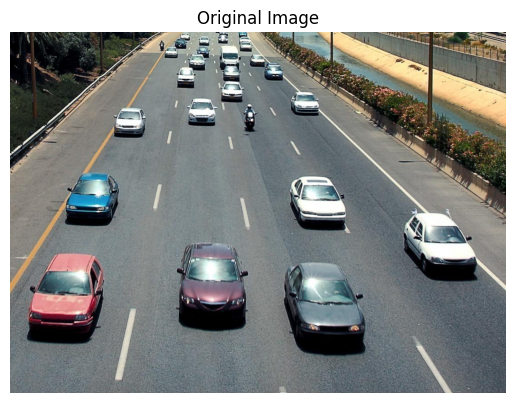

Prompts: ['<CAPTION>']
['A highway filled with lots of traffic next to a river.']


In [129]:
task = "<CAPTION>" # can replace with <DETAILED_CAPTION> or <MORE_DETAILED_CAPTION>

# base image
img_path = os.path.join(data_path, "base_object_detection.jpeg")
img = read_image(img_path)
display_image(img, "Original Image")

results = inference_florence(img, model, processor, task, device=device, torch_dtype=torch_dtype) 
combined_results = [result[task] for result in results]
print(combined_results)

#### Object Detection

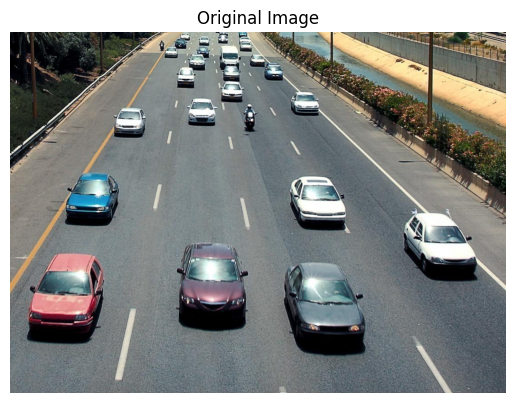

Prompts: ['<OD>']


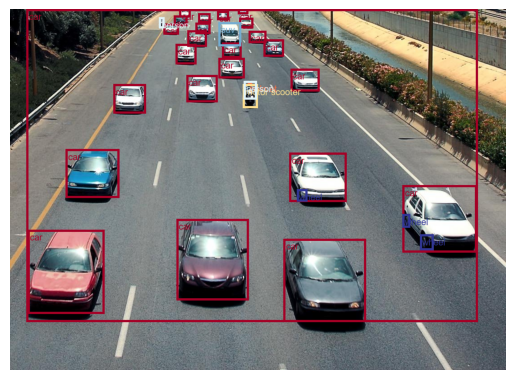

Prompts: ['Locate car in the image.', 'Locate motorbike in the image.', 'Locate van in the image.']


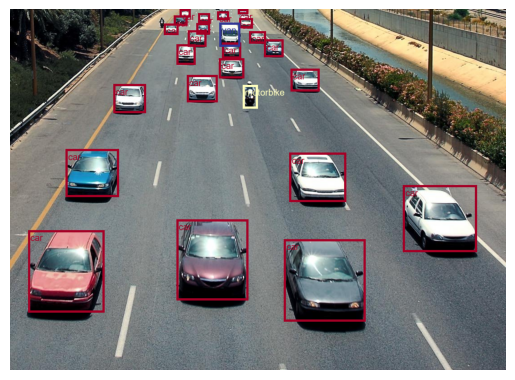

In [204]:
task = "<OD>"

# base image
img_path = os.path.join(data_path, "base_object_detection.jpeg")
img = read_image(img_path)
display_image(img, "Original Image")

# no classes/ prompts specified
results = inference_florence(img, model, processor, task, device=device, torch_dtype=torch_dtype) # run object detection for no specific classes
combined_results = {"bboxes": [box for result in results for box in result[task]["bboxes"]], "labels": [label for result in results for label in result[task]["labels"]]}
draw_bounding_boxes(img, combined_results, size_bb=5) # draw bounding boxes on image

# three classes/ prompts - better performance with enhanced prompt
# Iterate over calls to the model for each class
# NOTE! this replaces the task type with below prompts - see output below
classes = ["car", "motorbike", "van"]
prompts = [f"Locate {i} in the image." for i in classes]
results = inference_florence(img, model, processor, task, prompts=prompts, device=device, torch_dtype=torch_dtype) # run object detection for no specific classes
combined_results = {"bboxes": [box for result in results for box in result[task]["bboxes"]], "labels": [label for result in results for label in result[task]["labels"]]}
draw_bounding_boxes(img, combined_results, size_bb=5)

### Optical Character Recognition

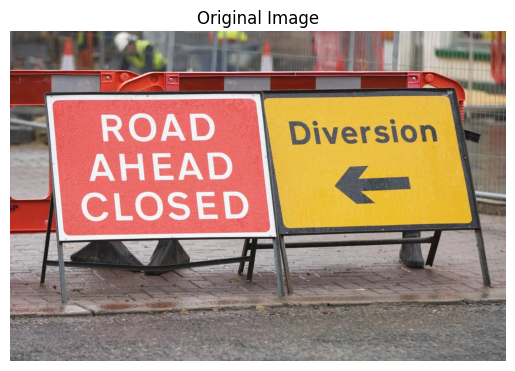

Prompts: ['<OCR>']
[{'<OCR>': 'ROADDiversionAHEADCLOSED'}]
Prompts: ['<OCR_WITH_REGION>']


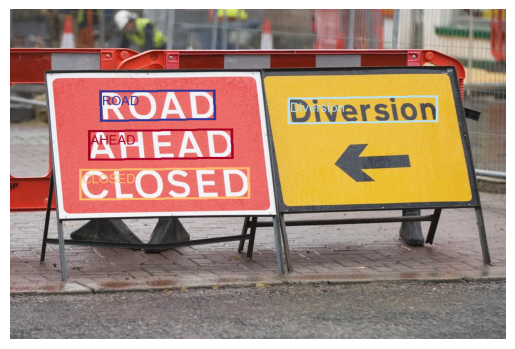

In [203]:
task = "<OCR_WITH_REGION>"

# base image
img_path = os.path.join(data_path, "base_ocr.jpg")
img = read_image(img_path)
display_image(img, "Original Image")

task = "<OCR>"
results = inference_florence(img, model, processor, task, device=device, torch_dtype=torch_dtype)
print(results)

task = "<OCR_WITH_REGION>"
results = inference_florence(img, model, processor, task, device=device, torch_dtype=torch_dtype)
combined_results = {"polygon": [box for result in results for box in result[task]["quad_boxes"]], "labels": [label.replace("</s>", "").replace("<s>", "") for result in results for label in result[task]["labels"]]}
draw_bounding_boxes(img, combined_results, size_bb=5, size_text=25)

#### Segmentation
Unfortunately, the Florence model does not support segmentation for multiple objects in the same image. This is a limitation. However, there is an easy way to get around this, demonstrated below.

In [ ]:
- `<REFERRING_EXPRESSION_SEGMENTATION>` Segmentation, given text
- `<REGION_TO_SEGMENTATION>` S

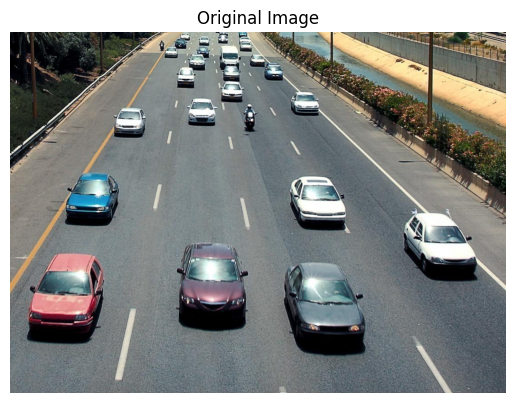

Prompts: ['<REFERRING_EXPRESSION_SEGMENTATION>cars']


In [ ]:
# base image
img_path = os.path.join(data_path, "base_object_detection.jpeg")
img = read_image(img_path)
display_image(img, "Original Image")

task = "<REFERRING_EXPRESSION_SEGMENTATION>cars"
pattern = r"(<[^>]+?>)"
base_task = re.findall(pattern, task)[0] # get the base task from the task string. This helps in cases where we add additional prompts to the task, such as in segmentation.
results = inference_florence(img, model, processor, task, device=device, torch_dtype=torch_dtype)
combined_results = {"polygons": [box[base_task]['polygons'][0][0] for box in results], "labels": [box[base_task]['labels'] for box in results]}
draw_bounding_boxes(img, combined_results, size_bb=5, size_text=25, label_bb=False, color_bb=False)

# <REGION_TO_SEGMENTATION>

In [ ]:
# can it only label one object???

# Unfortunately, the Florence model does not support segmentation for multiple objects in the same image. However, if we combine this with object detection, we can easily get around this limitation. Like so:
# with region to segmention???